<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/Collate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = '/content/drive/MyDrive/ANLP21/'

In [3]:
import pandas as pd
import random
import os
import re
import spacy
from collections import Counter
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [4]:
nlp = spacy.load("en_core_web_sm")
df = pd.concat([pd.read_csv(root+'concatenated/concatenated-%s.csv' % i) for i in range(1,5)])
df.head()

,Unnamed: 0,Unnamed: 0.1,film,item,CapableOf,Desires,MotivatedByGoal,xAttr,xNeed,xReact,xReason,xWant,Unnamed: 0.1.1
0,27637,256407,10_things_i_hate_about_you.txt,"KAT says, ""Leave it""","[' to leave it', ' leave the place', ' leave i...","[' to be left alone', ' to leave it alone', ' ...","[' KAT LEAVES IT.', ' KAT LEAVES IT', ' KAT LE...","[' independent', ' decisive', ' mean', ' deter...","[' to have something to leave', ' to know what...","[' good.', ' satisfied', ' relieved', ' happy'...","[' KAT DOES NOT WANT TO LEAVE', ' KAT DOES NOT...","[' to be left alone', ' to leave it alone', ' ...",NaN
1,27638,256489,10_things_i_hate_about_you.txt,"KAT says, ""Why didn't we just read the Hardy B...","[' read the book', ' learn something new', ' r...","[' to be entertained', ' read a book', ' to be...","[' KAT IS READING THE BOOK', ' KAT GETS READ T...","[' curious', ' Curious', ' thoughtful', ' inte...","[' to buy a book', ' to buy the books', ' to b...","[' happy.', ' happy', ' entertained', ' curiou...","[' The Hardy Boys are too boring.', ' KAT IS R...","[' to go to bed', ' to read more books', ' to ...",NaN
2,27639,256491,10_things_i_hate_about_you.txt,"KAT says, ""This book is about a guy and his fi...","[' read the book', ' read the story', ' read i...","[' to read a book', ' read the book.', ' to re...","[' PersonY asks what the book is about', ' the...","[' curious', ' content', ' knowledgeable', ' i...","[' to read the book', ' to have read the book'...","[' contented', ' happy', ' content', ' satisfi...","[' the book is not important', ' the book is n...","[' to read the book', ' to read another book',...",NaN
3,27640,256493,10_things_i_hate_about_you.txt,"KAT says, ""(continuing) Frankly, I'm baffled a...","[' PersonX tells PersonX to stop.', ' PersonX ...","[' good about themselves', ' sad', ' happy', '...","[' KAT HAS NO MONEY.', ' KAT HAS NO MONEY', ' ...","[' sadistic', ' sadist', ' mean spirited', ' i...","[' to talk about it', ' to have a cat', ' to t...","[' sadistic', ' happy.', ' sad', ' happy', ' a...","[' KAT HAS NO MONEY.', ' KAT HAS NO MONEY', ' ...","[' to tell everyone about it', ' to tell peopl...",NaN
4,27641,256499,10_things_i_hate_about_you.txt,"KAT says, ""I guess the school board thinks bec...","[' to be a good person', ' to get a good grade...","[' good about themselves', ' to be respected',...","[' angry', ' proud', ' happy', ' good', ' sad']","[' a bully', ' mean spirited', ' a coward', ' ...","[' to make a point', ' to make a statement', '...","[' good about themselves', ' proud', ' angry',...","[' angry', ' proud', ' none', ' happy', ' good']","[' to talk to the school board', ' to talk to ...",NaN


In [5]:
df.to_csv(root+'concatenated.csv')

In [109]:
relations = [ "xAttr",  "MotivatedByGoal", "xReact"]

vocabulary = set()
vocabulary_idf = {"xAttr": {},  "MotivatedByGoal": {}, "xReact": {}}

film_bags = {}

def register_in_bag(film, token, relation):
    if film not in film_bags:
      film_bags[film] = {}
    if(relation not in film_bags[film]):
      film_bags[film][relation] = Counter()
    film_bags[film][relation][token]+=1

    vocabulary.add(token)

    if(token not in vocabulary_idf[relation]):
      vocabulary_idf[relation][token] = set()
    vocabulary_idf[relation][token].add(film)

import string
  
def process_results(row):
    for relation in relations:
      film = row['film']
      results = row[relation].strip('][').split(', ')
      for result in results:
        result = result.translate(str.maketrans('', '', string.punctuation))
        tokens = result.split(' ')
        for token in tokens:
            token = token.replace('\'','').strip()
            if token != "" and token not in nlp.Defaults.stop_words:
              register_in_bag(film, token, relation)


df.apply(process_results, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
14458    None
14459    None
14460    None
14461    None
14462    None
Length: 87179, dtype: object

In [110]:
def vectorize(function_vec, vocabulary):
  vocabulary = list(vocabulary)
  film_vectors = []
  for film in film_bags:
    relation_bag = [] 
    for relation in film_bags[film]:
      vec = function_vec(film_bags, film, relation)
      d = len(vec)
      relation_bag.append(vec)
    film_vectors.append(relation_bag)

  X = np.array(film_vectors)
  w, h = len(film_vectors), len(relations)
  assert X.shape == (w, h, d)
  print(w, h, d)
  return X, w, h, d

In [111]:
import re
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath

# First we have to convert the Glove format into w2v format; this creates a new file
glove_file= root+"/glove.6B.100d.100K.txt"
glove_in_w2v_format= root+"/glove.6B.100d.100K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

glove = KeyedVectors.load_word2vec_format(root+"/glove.6B.100d.100K.w2v.txt", binary=False)

In [112]:
def plot_3d(X, w, h, d, Y):
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  z = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      z.append(value[2])
          
  plt.figure(figsize=(16, 16)) 
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, c=Y, cmap='viridis')


def plot_2d(X, w, h, d, Y):
  assert X.shape == (w, h, d)
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(16, 16)) 
  plt.scatter(x,y, c=Y, cmap='viridis')
  plt.show()

In [184]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
def elbow(X, w, h, d, vec_method, k_range):
      X = X.reshape((w,h*d))
      model = KMeans()
      visualizer = KElbowVisualizer(model, k=k_range)
      visualizer.fit(X)        
      visualizer.show()  

def silhouette(X, w, h, d, vec_method, k):
      X = X.reshape((w,h*d))
      model = KMeans(k, random_state=42)
      visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

      visualizer.fit(X)        # Fit the data to the visualizer
      visualizer.show() 

In [185]:
bag_of_words = lambda film_bags, film, relation: [1 if token in film_bags[film][relation] else 0 for token in vocabulary]
X, w, h, d = vectorize(bag_of_words, vocabulary)

444 3 9938


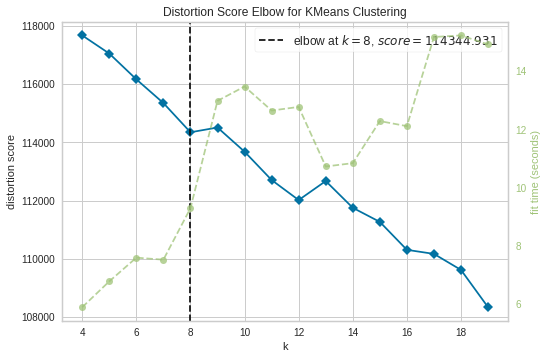

In [186]:
elbow(X, w, h, d, "Bag of words", (4, 20))

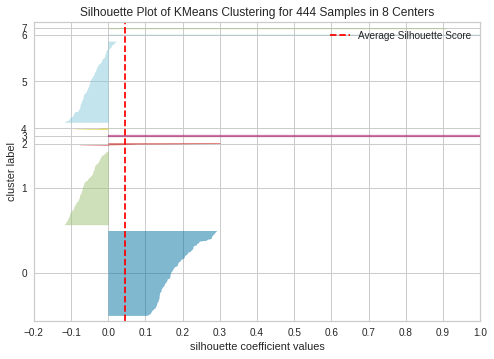

In [187]:
silhouette(X, w, h, d, "Bag of words", 8)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


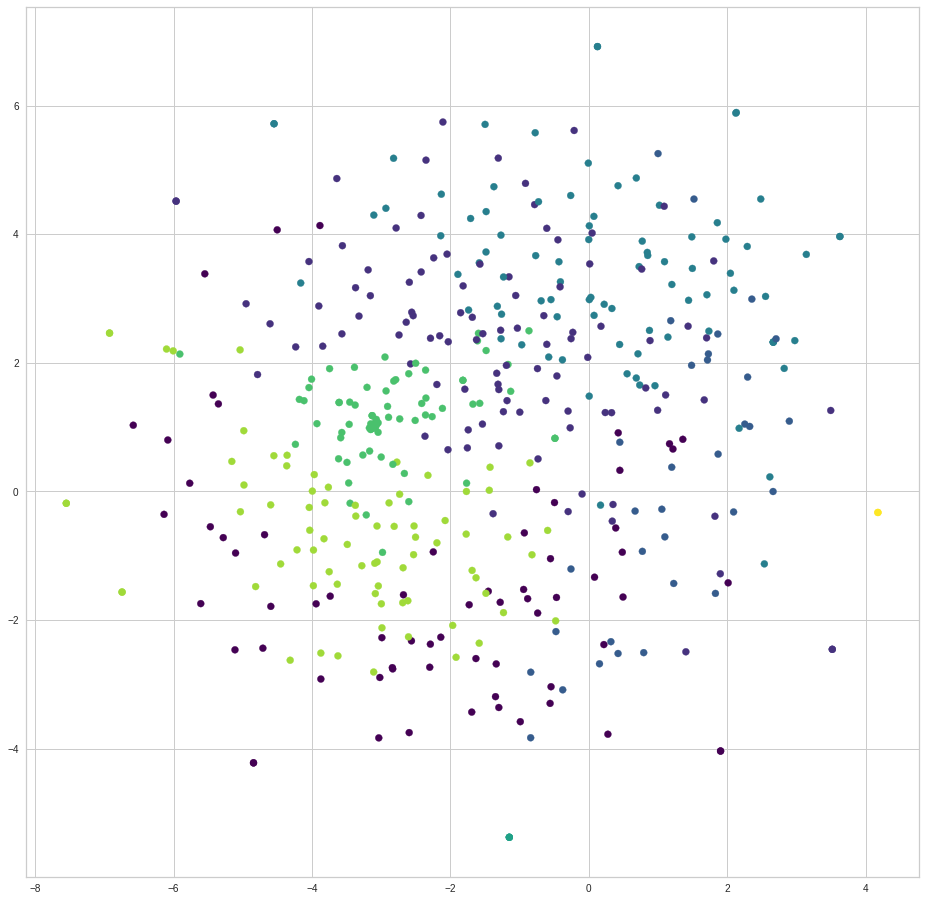

In [188]:
kmeans = KMeans(n_clusters= 8)
label = kmeans.fit_predict(X.reshape((w,h*d)))
plot_2d(X, w, h, d, label)
# plot_3d(X, w, h, d, label)

In [208]:
glovec =  lambda film_bags, film, relation: np.mean([glove[token] for token in film_bags[film][relation] if token in glove], axis=0).tolist()
X, w, h, d = vectorize(glovec, vocabulary)

444 3 100


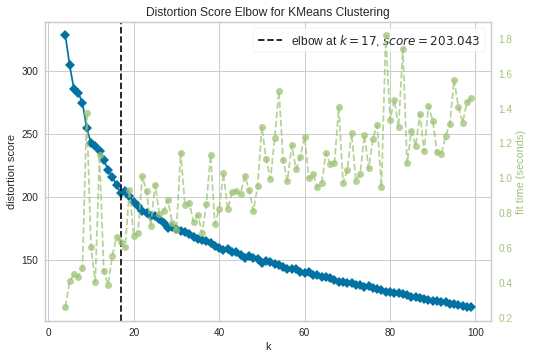

In [215]:
elbow(X, w, h, d, "Glovec", (4, 100))

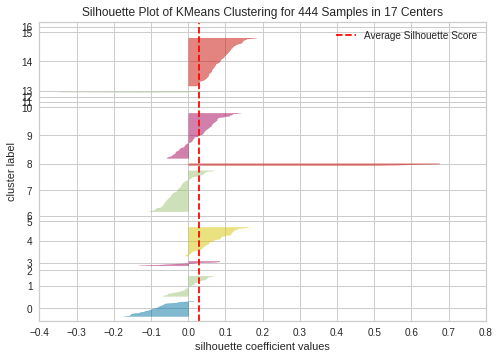

In [216]:
silhouette(X, w, h, d, "Glovec", 17)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


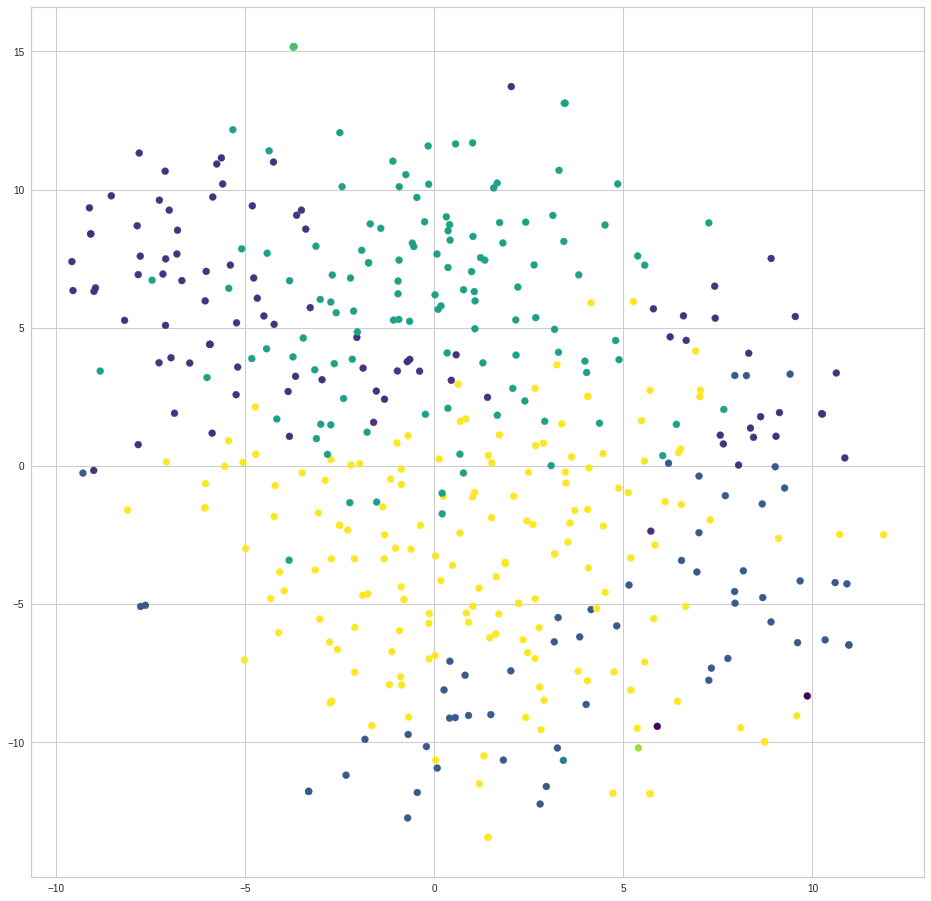

In [118]:
kmeans = KMeans(n_clusters= 8)
label = kmeans.fit_predict(X.reshape((w,h*d)))
plot_2d(X, w, h, d, label)
# plot_3d(X, w, h, d, label)

444 3 9938


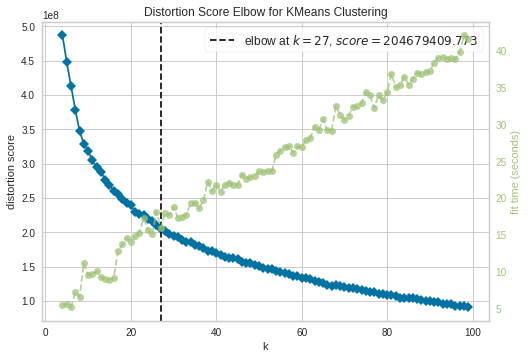

In [217]:
import math
def tf_idf(film_bags, film, relation):
  ret = []
  for token in vocabulary:
    if token in film_bags[film][relation]:
      tf = film_bags[film][relation][token]
      N = len(film_bags[film])
      n = len(vocabulary_idf[relation][token])
      idf = math.log(N/n) 
      ret.append(tf*idf)
    else:
      ret.append(0)
  return ret

X, w, h, d = vectorize(tf_idf, vocabulary)

elbow(X, w, h, d, "TF-IDF", (4, 100))

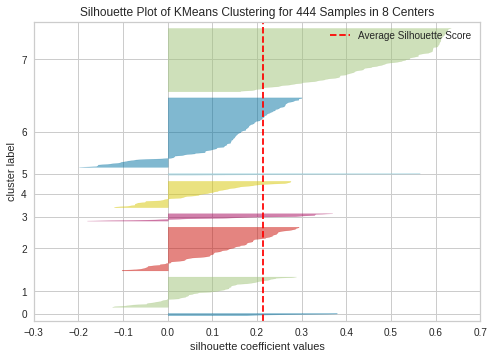

In [219]:
silhouette(X, w, h, d, "TFIDF", 8)

In [220]:
#Initialize the class object
kmeans = KMeans(n_clusters= 8)
label = kmeans.fit_predict(X.reshape((w,h*d)))

In [221]:
# plot_3d(X, w, h, d, label)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


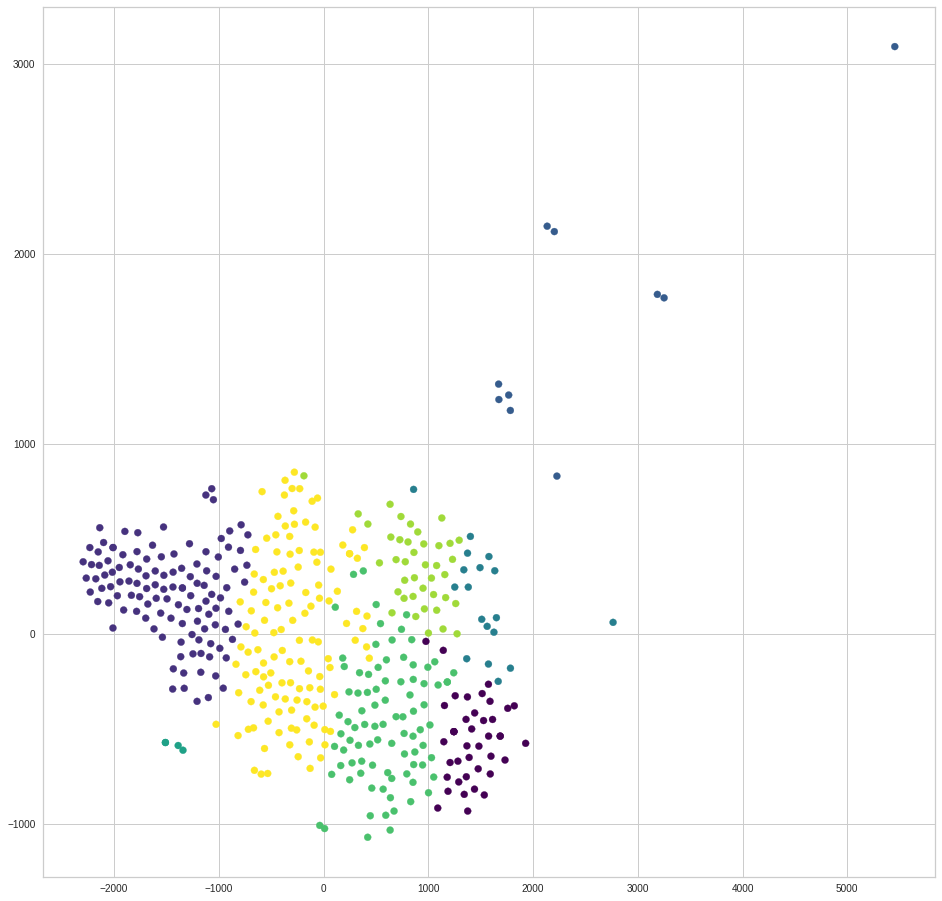

In [222]:
plot_2d(X, w, h, d, label)

In [223]:
df = pd.read_csv('/content/drive/MyDrive/ANLP21/database.csv')
film_list = [film for film in film_bags]
df['cluster'] = df['film'].apply(lambda x: label[film_list.index(x)] if x in film_list else None)

df

,Unnamed: 0,film,scene,item_ids,item,character,protagonist,cluster
0,0,trainspotting.txt,1,1,TRAINSPOTTING,NaN,RENTON,7.0
1,1,trainspotting.txt,1,2,Screenplay by John Hodge,NaN,RENTON,7.0
2,2,trainspotting.txt,1,3,Based on the Novel by Irvine Welsh,NaN,RENTON,7.0
3,3,trainspotting.txt,1,4,Shooting Draft,NaN,RENTON,7.0
4,4,trainspotting.txt,2,1,STREET - DAY,NaN,RENTON,7.0
...,...,...,...,...,...,...,...,...
905246,905246,an_american_werewolf_in_paris.txt,69,5,"ANDY says, ""Yeah. It was just, um... something...",ANDY,ANDY,2.0
905247,905247,an_american_werewolf_in_paris.txt,69,6,"The stewardess nods and smiles, a little uneas...",NaN,ANDY,2.0
905248,905248,an_american_werewolf_in_paris.txt,70,1,AIRPLANE,NaN,ANDY,2.0
905249,905249,an_american_werewolf_in_paris.txt,70,2,"It flies along over a blanket of clouds, past ...",NaN,ANDY,2.0


In [156]:
df1 = df.groupby('cluster')
df2 = df1.get_group(0)
df2['film'].unique()

array(['fatal_instinct.txt', 'bodies_rest_and_motion.txt',
       'conspiracy_theory.txt', 'marty.txt', 'jane_eyre.txt',
       'bad_santa.txt', 'an_american_werewolf_in_london.txt',
       'all_about_eve.txt', 'the_godfather.txt', 'memento.txt',
       'four_rooms.txt', 'the_godfather_part_2.txt', 'carnivore.txt',
       'ghost.txt', 'forrest_gump.txt', 'henry_fool.txt',
       'sweet_smell_of_success.txt', 'the_assignment.txt',
       'frequency.txt', 'hardcore.txt', 'birthday_girl.txt',
       'the_searchers.txt', 'jay_and_silent_bob_strike_back.txt',
       'hannah_and_her_sisters.txt', 'life_as_a_house.txt',
       'assassins.txt', 'the_sixth_sense.txt', 'the_grifters.txt',
       'the_time_machine.txt', 'taking_sides.txt',
       'bringing_out_the_dead.txt', 'sex_lies_and_videotapes.txt',
       'dark_angel__pilot.txt', 'willow.txt', 'the_cable_guy.txt',
       'the_thing.txt', 'the_anniversary_party.txt',
       'schindlers_list.txt', 'beloved.txt', 'the_ploughmans_lunch.txt',
 

In [165]:
df1 = df[['film','protagonist','cluster']]
df1 = df1.drop_duplicates()
df1.to_csv(root+"clustered_characters.csv")